# Kielen ja kirjallisuuden digitaalista analyysia

*teknisiä valmisteluja..*

In [4]:
!python -m spacy download fi_core_news_sm
!pip install advertools
!python -m spacy download en_core_web_sm
!pip install gensim==4.2.0
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 9.4/14.3 MB 366.5 kB/s eta 0:00:14^C4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 9.4/14.3 MB 366.5 kB/s eta 0:00:14
ERROR: Operation cancelled by user

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

Aborted!



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# kopioi github-repositorio tarvittavia tiedostoja varten

In [ ]:
!git clone https://github.com/telmaau/digikirjallisuus/

Cloning into 'digikirjallisuus'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 3), reused 28 (delta 3), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [154]:
# helper functions
import spacy
import pandas as pd
from random import sample
import glob
import re

nlp= spacy.load("fi_core_news_sm")
import advertools as adv

stopwords=adv.stopwords['finnish']
print(sorted(stopwords)[:5])
from digikirjallisuus.styloutils import *  
from digikirjallisuus.utils import *  

['aiemmin', 'aika', 'aikaa', 'aikaan', 'aikaisemmin']


In [ ]:

def clean_text(
    txt: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=stopwords,
    processing="lemmas"
    ) -> str:
    
    """
    A method to clean text 
    """

    if processing == "lemmas":
      doc = nlp(txt)
      #lemmas=[token.lemma_ for token in doc if token.pos_ != "PUNCT"]
      lemmas=[token.lemma_ for token in doc if token.pos_ in ["VERB", "NOUN" ,"ADJ" ,"ADV"]]
      string=" ".join([l for l in lemmas if len(l)>2]) # vain sanat, jotka yli kaksi kirjainta pitkiä

    elif processing =="none":
      # Cleaning the urls
      string = re.sub(r'https?://\S+|www\.\S+', '', txt)

      # Cleaning the html elements
      string = re.sub(r'<.*?>', '', string)

      # Removing the punctuations
      for x in string.lower(): 
          if x in punctuations: 
              string = string.replace(x, "") 

    else:
      # Cleaning the urls
      string = re.sub(r'https?://\S+|www\.\S+', '', txt)

      # Cleaning the html elements
      string = re.sub(r'<.*?>', '', string)

      txt=txt.translate(translate_table)
      stems = stemmer.stem(txt)
      
      string=" ".join([s for s in stems.split() if len(s)>1])

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string  

## Tehtävä 1a): tarkastele Melvillen Moby Dickiä

In [4]:
# prepare a corpus

with open("digikirjallisuus/data/melville_valas.txt", encoding='latin-1') as fp:
  txt=fp.read()
  txt_split=txt.split("\n")
  txt=txt.replace("\n", " ")

print(txt[:200], "\n")


# syötä teksti NLP-algoritmille
doc= nlp(txt)
print("merkkimäärä:", len(doc),"\n")


Ollessani joitakin vuosia sitten -- kauanko siitä tarkalleen on, ei suuria merkitse -- melkeinpä tyhjätaskuna ja alettuani kammota maankamaraa, juolahti mieleeni ajatus lähteä vesille oppiakseni tunte


In [32]:

# Nyt jokaiselle sanalle on tiedossa kieliopillisia elementtejä:

df=pd.DataFrame()

# iteroi sanat pätkästä tekstiä:
for token in doc[50:120]:
    
    temp=pd.Series([token.text,token.lemma_,token.pos_, token.dep_]).to_frame().T
    df=pd.concat([df,temp], axis=0, ignore_index=True)
    
display(df.head(15))

# mitä sarakkeet esittävät?

,0,1,2,3
0,lokaisen,lokainen,ADJ,amod
1,marraskuun,marraskuu,NOUN,nmod:poss
2,kylmyys,kylmyys,NOUN,nsubj
3,painaa,painaa,VERB,advcl
4,sielua,sielu,NOUN,obj
5,;,;,PUNCT,punct
6,kun,kun,SCONJ,mark
7,tahtomattaan,tahtomattaan,NOUN,obj
8,jää,jäädä,VERB,advcl
9,seisomaan,seisoa,VERB,xcomp


### Sanoista vektoreiksi!

Seuraavan tehtävän korpuksena käytetään pientä romaanivalikoimaa.
Niiden sanoista muodostetaan vektoreita sen perusteella, minkä muiden sanojen läheisyydessä
ne esiintyvät.

## Tehtävä 1b) kouluta sanavektoreita 
Korpuksena käytetään kokoelmaa romaaneja, jotka näet alla.

In [64]:
# add the whole corpus

import glob

texts= glob.glob("digikirjallisuus/data/*txt")
my_corpus=[]
novels={}
for a_text in texts:
  print(a_text)
  encodings = ['utf-8', 'latin-1', 'windows-1252']
  for e in encodings:
      try:
          with open(a_text, encoding=e) as fp:
            txt=fp.read()
            txt=txt.replace("\n", " ")
      except UnicodeDecodeError:
          print('got unicode error with %s , trying different encoding' % e)
      else:
          print('opening the file with encoding:  %s ' % e)
          break
  
  
  clean=clean_text(txt)
  novels[a_text.split("/")[-1].replace(".txt","")] = clean
  my_chunks=chunks(clean.split(), 7)
  print(len(my_chunks),len(my_corpus))
  my_corpus+=my_chunks

data/montgomery_runotytto.txt
got unicode error with utf-8 , trying different encoding
opening the file with encoding:  latin-1 
5460 0
data/dickens_saiturin_joulu.txt
got unicode error with utf-8 , trying different encoding
opening the file with encoding:  latin-1 
1595 5460
data/doyle_baskervillen_koira.txt
got unicode error with utf-8 , trying different encoding
opening the file with encoding:  latin-1 
3909 7055
data/grimm_satuja.txt
opening the file with encoding:  utf-8 
5019 10964
data/iris_rukka.txt
opening the file with encoding:  utf-8 
2280 15983
data/kivi_seitseman_veljesta.txt
got unicode error with utf-8 , trying different encoding
opening the file with encoding:  latin-1 
6539 18263
data/liisa_ihmemaassa.txt
opening the file with encoding:  utf-8 
1340 24802
data/lehtonen_putkinotko.txt
got unicode error with utf-8 , trying different encoding
opening the file with encoding:  latin-1 
7508 26142
data/melville_valas.txt
got unicode error with utf-8 , trying different encod

#### Koulutetaan vektorimalli:
kaikki kirjojen lauseet syötetään nyt word2vec-algoritmille, joka luo niistä vektoreita.

In [56]:
from gensim.models import Word2Vec
# define training data
sentences = my_corpus

# train model
model = Word2Vec(sentences, 
    min_count=10, # sanan täytyy esiintyä vähintään 10 kertaa
    window = 2, # katsotaan kahta lähintä sanaa ympärillä
    vector_size=150, # kuinka monta ulottuvuutta vektorille annetaan
    sg=1)
    
# summarize the loaded model
print(model)


2022-10-25 20:05:21,431 | INFO | word2vec.py:579 | scan_vocab | collecting all words and their counts
2022-10-25 20:05:21,434 | INFO | word2vec.py:562 | _scan_vocab | PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-25 20:05:21,467 | INFO | word2vec.py:562 | _scan_vocab | PROGRESS: at sentence #10000, processed 69992 words, keeping 21548 word types
2022-10-25 20:05:21,502 | INFO | word2vec.py:562 | _scan_vocab | PROGRESS: at sentence #20000, processed 139985 words, keeping 37762 word types
2022-10-25 20:05:21,523 | INFO | word2vec.py:562 | _scan_vocab | PROGRESS: at sentence #30000, processed 209979 words, keeping 54543 word types
2022-10-25 20:05:21,539 | INFO | word2vec.py:562 | _scan_vocab | PROGRESS: at sentence #40000, processed 279973 words, keeping 68773 word types
2022-10-25 20:05:21,560 | INFO | word2vec.py:585 | scan_vocab | collected 77391 word types from a corpus of 340457 raw words and 48641 sentences
2022-10-25 20:05:21,561 | INFO | word2vec.py:63

Word2Vec<vocab=4226, vector_size=150, alpha=0.025>


In [57]:
# printtaa kaikki sanat, jotka korpuksesta löytyvät:
words=list(model.wv.key_to_index.keys())
print(sorted(words) ) # sorted järjestää ne aakkosjärjestykseen


['aallo', 'aalta', 'aalto', 'aamiainen', 'aamu', 'aamupäivä', 'aamusta', 'aapeli', 'aapiskirja', 'aarnikotka', 'aasi', 'aatos', 'aave', 'aavistaa', 'aavistus', 'aha', 'ahaa', 'ahdistaa', 'ahkera', 'ahkerasti', 'aho', 'aholla', 'aholle', 'aida', 'aihe', 'aiheuttaa', 'aikei', 'aikoa', 'aikoivat', 'aikomus', 'ainapa', 'aine', 'ainoakaan', 'ainoastaan', 'ainoata', 'aio', 'aioin', 'airo', 'aita', 'aito', 'aitta', 'aittaan', 'aivo', 'aja', 'ajaa', 'ajaja', 'ajatelka', 'ajatella', 'ajatelleeksi', 'ajattelea', 'ajatukse', 'ajatuksi', 'ajatuksissaan', 'ajatus', 'ajoia', 'ajoissa', 'ajoista', 'ajuri', 'akka', 'akkuna', 'akkuta', 'ala', 'alainen', 'alakuloinen', 'alakuloisesti', 'alaspäin', 'alasti', 'alati', 'alhaalla', 'alistua', 'alituisesti', 'alkaa', 'alku', 'alue', 'alus', 'ammatti', 'ammentaa', 'ampua', 'ankara', 'ankarasti', 'anna', 'annaa', 'annatte', 'annoin', 'annos', 'ansaita', 'ansio', 'anta', 'antaisi', 'antakaa', 'antautua', 'anteeksi', 'anthony', 'apteekkari', 'arasti', 'arka', 'a

In [58]:
# tältä näyttää yksi sana

a_word= sample(words,1)
print(a_word)
print(model.wv[a_word])

['rinte']
[[ 0.01286094 -0.01466171 -0.03906083 -0.01216927  0.01698427  0.05247886
   0.03195816  0.23271115 -0.01060854 -0.02183883  0.05441575 -0.01783372
  -0.02406518  0.04312985 -0.18544841 -0.02692709  0.09610198 -0.00488692
   0.08092853  0.05318581 -0.04184052 -0.0893167   0.13398951  0.09005199
   0.06458302 -0.03727978 -0.07764141 -0.06429751 -0.11464549  0.0140676
  -0.02512641  0.13256617 -0.06977911 -0.03324849  0.02267065  0.09588963
   0.09572399 -0.13073428  0.07849792 -0.00891776  0.00109322  0.06165425
  -0.16513814 -0.01925195  0.10243794  0.0246301  -0.02753539 -0.00647835
  -0.09357216  0.1703517  -0.04611951  0.05843361 -0.05074454 -0.02582412
   0.04717181  0.02105834  0.07834963  0.02512678  0.05384016  0.04236022
  -0.05051211 -0.10108789 -0.00402677  0.02738244 -0.06122374  0.02541855
   0.00739578 -0.16414876 -0.10671427  0.00632984  0.05244048  0.11113285
   0.00966004 -0.16931145 -0.06132707 -0.01384354 -0.09739494  0.12253053
  -0.09729322  0.02673545  0.

### Toimivatko analogiat?


In [59]:
result = model.wv.most_similar(positive=['isä', 'poika'], negative=['äiti'], topn=5)
print(result, "\n")

result = model.wv.most_similar(positive=['veli', 'poika'], negative=['sisar'], topn=5)
print(result, "\n")

result = model.wv.most_similar(positive=['kala', 'vesi'], negative=['lintu'], topn=5)
print(result, "\n")


result = model.wv.most_similar(positive=['taivas', 'ilma'], negative=['meri'], topn=5)
print(result, "\n")


[('lapsi', 0.9759836792945862), ('veli', 0.9726880192756653), ('ystävä', 0.9711704254150391), ('täti', 0.9684512615203857), ('ukko', 0.9682508707046509)] 

[('herra', 0.9781523942947388), ('rouva', 0.9774029850959778), ('ystävä', 0.9694636464118958), ('vastata', 0.9691159129142761), ('neiti', 0.9658707976341248)] 

[('laiva', 0.9878067970275879), ('veljeknen', 0.9861051440238953), ('tuuli', 0.9837737083435059), ('vene', 0.9835675954818726), ('kukka', 0.9835522770881653)] 

[('musta', 0.9862765073776245), ('näkyä', 0.9758521914482117), ('valkoinen', 0.9743664264678955), ('punainen', 0.9725748300552368), ('valkea', 0.970385730266571)] 



In [62]:
# löydä lähimmät sanat
model.wv.most_similar(positive=["meri"], topn=10)

[('tuuli', 0.9911205768585205),
 ('vähitellen', 0.9910450577735901),
 ('pinta', 0.9907771944999695),
 ('kirkas', 0.9907158613204956),
 ('kasvaa', 0.990147590637207),
 ('lyhyt', 0.9899951815605164),
 ('liikkua', 0.9899125695228577),
 ('veljeknen', 0.9898662567138672),
 ('harmaa', 0.989798903465271),
 ('puhaltaa', 0.9893892407417297)]

In [63]:
# kokeile eri sanapareja
# ovatko etäisyydet loogisia?

print(model.wv.similarity('tyttö', 'nainen'))
print(model.wv.similarity('tyttö', 'talo'))

0.94801795
0.8329531


In [77]:
# katsahdus kontekstiin
from nltk.text import Text

# nimeä vaihtamalla voit tutkia eri romaaneja
nimi="melville_valas"
test_text=Text(novels[nimi].split())

test_text.concordance("valas", 60,lines=10) # kokeile valaan paikalla muita sanoja

# paljastavatko sanat jotakin olennaista valaasta?

Displaying 10 of 86 matches:
kuvaille rottakoira doggia koira naurtaa tuntea vakuutetuks
den istunut huone odottama koira tottua käydä herransa jäle
iä keppi jokseenkin raskas koira kantanut selvä nähdä hampa
nut selvä nähdä hampa jäli koira leuka merkki etäisyys näyt
n varma yksinkertainen syy koira seisoa ulkona portaat omis
kertomus riittää puhe suku koira tilaisuudesta näyttäytyä p
rottaa ääni sanoa yllyttää koira jälilleen kuulla juosta ul
tsisia tamma laskisia irti koira tapahtua koira haistaa hui
skisia irti koira tapahtua koira haistaa huiva tyttö pudott
tsastaa saavuttiva vihdoin koira tunneta rohkeudesta erinom


## Stylometria

### Tehtävä 1: tekstien tyylipiirteitä

In [80]:
# lataa uusi korpus

fp = "digikirjallisuus/data/stylo_1/"
texts=glob.glob(str(fp+"*.txt"))


corpus={}
for t in texts:
    name= t.split("/")[-1].replace(".txt","")
    print(name)
    with open(t, encoding='utf-8') as fp:
        
        txt=fp.read()
        txt=txt.replace("\n", " ")
    corpus[name]=txt



kianto_muistlemia
gulliverin_matkat
tarzan
pikku_naisia
ylpeys_ja_ennakkoluulo
peter_pan


In [82]:
# aputyökaluja
from digikirjallisuus.stylometryutils import CustomStatTransformer
from sklearn.pipeline import Pipeline


# analyst on tekstianalyytikkomme
analyst=CustomStatTransformer()

my_pipeline  = Pipeline(
    steps=[
        ("stats", analyst),
    ]
)

# analysoi korpus
texts = [" ".join(v.split()[:5000]) for v in corpus.values()]
fts = my_pipeline.fit_transform(texts) 


Analysaattori käsittelee jokaisen tekstin ja laskee siitä halutut ominaisuudet.

Selitykset:
- TTR eli Type-Token ratio = kuinka monta uniikkia sanaa (type) kokonaissanamäärään verrattuna. Mitä suurempi arvo, sen rikkaampi on tekstin sanasto. Arvo vaihtelee välillä 0 ja 1.
- MATTR = sama kuin edellinen, mutta laskettuna katkelmista läpi tekstin, jottei romaanin kokonaispituus vääristä tulosta.
- "verbejä" kertoo kuinka moni romaanin sanoista on sanaluokaltaan verbejä.
- "adjektiiveja" kertoo saman suhdeluvun adjektiiveista.
- lausepituus on keskimääräinen lausepituus.

In [85]:
for i,v in enumerate(fts.values()):
    print(list(corpus.keys())[i])
    print("TTR", round(v["ttr"],3))
    print("MATTR", round(v["mattr"],3))
    print("verbejä", round(v["verb_fraction"],3))
    print("adjektiiveja", round(v["adj_fraction"],3))
    print("lausepituus:", round(v["mean_sent_length"],3))
    print("\n")
    
# Mitä tulokset kertovat (jos mitään)?

kianto_muistlemia
TTR 0.522
MATTR 0.788
verbejä 0.16
adjektiiveja 0.079
lausepituus: 17.323


gulliverin_matkat
TTR 0.55
MATTR 0.809
verbejä 0.167
adjektiiveja 0.073
lausepituus: 17.593


tarzan
TTR 0.537
MATTR 0.803
verbejä 0.176
adjektiiveja 0.075
lausepituus: 18.905


pikku_naisia
TTR 0.527
MATTR 0.779
verbejä 0.182
adjektiiveja 0.078
lausepituus: 16.344


ylpeys_ja_ennakkoluulo
TTR 0.465
MATTR 0.765
verbejä 0.161
adjektiiveja 0.078
lausepituus: 18.38


peter_pan
TTR 0.439
MATTR 0.727
verbejä 0.19
adjektiiveja 0.067
lausepituus: 13.178




## Tehtävä 2

Vertaile kahden suomalaisen kirjailijan, Juhani Ahon ja Ilmari Kiannon tekstejä.
VOisiko algoritmi päätellä tuntemattoman tekstin kirjailijan?

In [86]:
import scipy.spatial.distance as scidist
import sklearn.model_selection as model_selection
import sklearn.feature_extraction.text as sktext
import sklearn.preprocessing as preprocessing
from digikirjallisuus.styloutils import *


In [112]:
# lataa tunnetut teokset

fp = "digikirjallisuus/data/stylometria_data/"
texts=glob.glob(str(fp+"*train.txt"))

# jokainen kirja ladataan 5000 sanan pätkinä, 
# jottei eriävä pituus vaikuttaisi tuloksiin
train_documents, train_authors, train_titles=load_texts(texts, 5000) 

# sanojen sijaan vektoreita koko tekstistä
vectorizer = sktext.CountVectorizer(max_features=40,token_pattern=r"(?u)\b\w+\b")
v_train_documents = vectorizer.fit_transform(train_documents).toarray()
v_train_documents = preprocessing.normalize(v_train_documents.astype(float), norm='l1')


print("\n funktiosanoja, joiden avulla kirjailijat voisi erottaa toisistaan:")
print(vectorizer.get_feature_names_out()[:10])
delta = Delta().fit(v_train_documents, train_authors)

kianto_punainen_viiva_train
['1', 'mikä', 'ääretö', 'hiljaisuus', 'vallitsikaan']
aho_1_train
['i.', 'elli', 'olla', 'hän', 'nimi']
kianto_nirvana_train
['1.', '.', 'ihana', 'kevät', ',']
kianto_vanha_pappila_train
['1.', '.', 'vinttikamarikirja', '.', 'motto']
aho_2_train
['i.', 'mies', '--', 'pitkäselkä', ',']
aho_rautatie_train
['i.', 'pakkanen', 'paukka', 'nurkka', ',']


In [115]:
# lataa tuntematon kirjailija

f="digikirjallisuus/data/stylometria_data/unknown.txt"
test_docs, test_authors, test_titles = load_text(f,5000)
v_test_docs = vectorizer.transform(test_docs).toarray()
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')

unknown


Tässä vaiheessa voisit myös avata tekstitiedoston ja vertailla sitä Ahon ja Kiannon teoksiin.

Kumman käsialaa luulisit sen olevan?

In [116]:
# Annetaan algoritmin ennustaa!

predictions = delta.predict(v_test_docs, metric='cosine')
for filename, prediction in zip(test_titles, predictions):
    print(f'{filename} -> {prediction}')

unknown -> kianto
unknown -> kianto
unknown -> kianto
unknown -> kianto
unknown -> kianto
unknown -> kianto


In [117]:
## clustering

vectorizer = sktext.CountVectorizer(token_pattern=r"(?u)\b\w+\b")#, vocabulary=vocab)

v_documents = vectorizer.fit_transform(train_documents).toarray()
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1')
scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(f'N={v_documents.shape[0]} documents with '
      f'V={v_documents.shape[1]} features.')

N=42 documents with V=35258 features.


### Hierarkkinen klusterianalyysi

Kuvaaja haarautuu sen mukaan, miten lähellä toisiaan tekstit ovat.

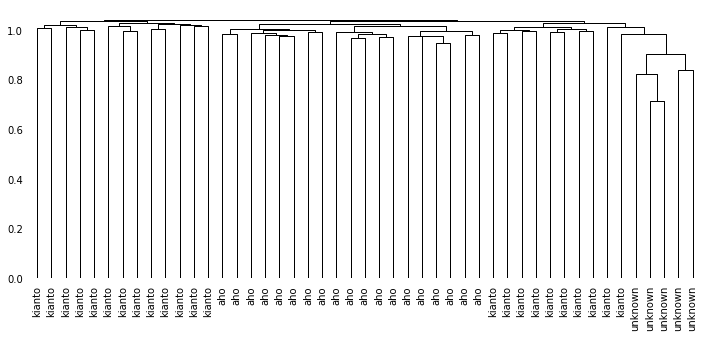

In [121]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

def plot_tree(linkage_object, labels, figsize=(10, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

v_test_docs = vectorizer.transform(test_docs[1:])
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')
v_test_docs = scaler.transform(v_test_docs.toarray())

all_documents = np.vstack((v_documents, v_test_docs))

dm = scidist.pdist(all_documents, 'cosine')
linkage_object = hierarchy.linkage(dm, method='complete')

plot_tree(linkage_object, train_authors + test_titles[1:], figsize=(12, 5))

### PCA 

Moniulotteiset tekstivektorit voidaan redusoida kaksiulotteisiksi PCA-menetelmällä (Principal Component Analysis)

In [126]:
# PCA

import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

print("alkuperäinen ulottuvuusmäärä:", v_documents.shape[1])
print("redusoitu ulottuvuusmäärä:", documents_proj.shape[1])

alkuperäinen ulottuvuusmäärä: 35258
redusoitu ulottuvuusmäärä: 2


Piirrä redusoidut vektorit kuvaajaan. Kumpikin kirjailija saa tässä kuvassa oman värinsä.
Vaihtamalla sanoja voit kokeilla, miten eri funktiosanojen käyttö jakaa kirjailijoiden tyylejä:

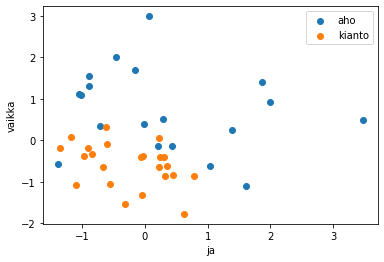

In [130]:
words = list(vectorizer.get_feature_names_out())
authors = np.array(train_authors)

# kokeile eri sanoja tähän:
sana_1="ja"
sana_2="vaikka"
x = v_documents[:, words.index(sana_1)]
y = v_documents[:, words.index(sana_2)]

fig, ax = plt.subplots()
for author in set(authors):
    ax.scatter(x[authors==author], y[authors==author], label=author)
ax.set(xlabel=sana_1, ylabel=sana_2)
plt.legend();

## Kvantitatiivinen draaman kaari

Samoin kuin muita merkityksiä, sanoihin assosioituu myös tunteita. 
Tätä positiivista tai negatiivista assosiaatiota voi mallintaa koneellisesti numeerisin arvoin.
On havaittu, että näitä arvoja käyttämällä voi mallintaa tarinan draaman kaaren kehitystä.
Ajatus perustuu siihen, että mitä jännittävämmäksi tai surullisemmaksi juoni muuttuu, sitä negatiivisempaa on myös käytetty sanasto.

In [137]:
# aputyökaluja

import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
nltk.download('vader_lexicon')
import re

# color words
import spacy
nlp_eng = spacy.load("en_core_web_sm")
import json
from digikirjallisuus.dacycolorizer import color_text

# tämä tehtävä toteutetaan englanniksi, ja voit valita seuraavista teksteistä:
print(gutenberg.fileids(), "\n")

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt'] 



[nltk_data] Downloading package punkt to
[nltk_data]     /u/98/peurat1/unix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /u/98/peurat1/unix/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [138]:
book= 'shakespeare-macbeth.txt' # valitse tähän haluamasi kirja
    

novel = nltk.corpus.gutenberg.raw(book)
start_index = novel.find("]") +1
print(book)
novel=novel[start_index:]
pattern = re.compile(r'\s+')
novel = re.sub(pattern, ' ', novel)
print(novel[:50], "\n")

# get sentences
sentences = sent_tokenize(novel)
for s in sentences[:3]:
    print(s, "\n")

shakespeare-macbeth.txt
 Actus Primus. Scoena Prima. Thunder and Lightning 



In [140]:
# valmistellaan tunneanaöysaattori

from nltk.sentiment.vader import SentimentIntensityAnalyzer

vadAnalyzer = SentimentIntensityAnalyzer()

from digikirjallisuus.helpers import *

In [141]:
# Hae tunnesanakirjasta numeeriset arvot 

sentiments = []
vad_scores =[]

# toista jokaiselle lauseelle:
for s in sentences:
    vad_s = vadAnalyzer.polarity_scores(s)
    
    
Hs,arcs = [],[]

res= {}

vad_arc =[]

for s in sentences:
    vad_s = vadAnalyzer.polarity_scores(s.lower())["compound"]
    vad_arc.append(vad_s)
    
vad_h = get_Hurst(vad_arc)


res = {"Hurst_vad":vad_h, "arc_vad": vad_arc}

# piirrä kuvaaja

story_arc = res["arc_vad"]
draw_figure(story_arc, "", book.replace(".txt","").replace("_"," "))

Minkälaiset sanat ovat "sanakirjassa"? Kokeile eri tekstipätkiä!

In [150]:
# värjää tekstiä sanakirjaosumien mukaan
# ovatko värit oikein? Puuttuuko jotakin olennaista?
colortxt=color_text(novel[1000:2000], nlp_eng, "plot")